In [1]:
import os
import random
from dataclasses import dataclass
import math
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch import amp
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

@dataclass
class Configuration:
    data_root: str = "/content/drive/MyDrive/DeepLearningTubes/Preprocessed"

    # HYPERPARAMETER
    epochs = 100
    lr = 1e-3
    weight_decay = 1e-3
    label_smoothing = 0.0
    img_size = 224
    batch_size = 64
    num_workers = 0

    # ArcFace hyperparams
    s = 25.0   # Scaling Factor untuk nilai cosine sebelum ke CrossEntropy.
    m = 0.3 # margin sudut

    val_ratio = 0.2
    seed = 42

config = Configuration()
print(config)

Using device: cuda
Configuration(data_root='/content/drive/MyDrive/DeepLearningTubes/Preprocessed')


In [3]:
def set_seed(seed = 32):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(config.seed)

In [5]:
class LoadDataset(Dataset):
    """
    image_paths : list lokasi file gambar
    labels      : list label numerik (misal 0..69)
    transform   : augmentasi & normalisasi
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

def scan_dataset(root_dir):
    image_paths = []
    labels = []

    classes = sorted(os.listdir(root_dir))
    classes = [c for c in classes if os.path.isdir(os.path.join(root_dir, c))]
    label_map = {cls_name: i for i, cls_name in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
                fpath = os.path.join(cls_dir, fname)
                image_paths.append(fpath)
                labels.append(label_map[cls])

    print("Total classes:", len(classes))
    print("Total images :", len(image_paths))
    return image_paths, labels, label_map

def split_dataset(paths, labels, val_ratio=0.2, seed=42):
    random.seed(seed)
    label_to_indices = {}

    for i, lbl in enumerate(labels):
        label_to_indices.setdefault(lbl, []).append(i)

    train_idx, val_idx = [], []
    for lbl, idxs in label_to_indices.items():
        random.shuffle(idxs)
        n_val = max(1, int(len(idxs) * val_ratio))
        val_idx.extend(idxs[:n_val])
        train_idx.extend(idxs[n_val:])

    train_paths = [paths[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_paths = [paths[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    print("Train samples:", len(train_paths))
    print("Val samples  :", len(val_paths))
    return train_paths, train_labels, val_paths, val_labels

# split dataset
all_paths, all_labels, label_map = scan_dataset(config.data_root)
train_paths, train_labels, val_paths, val_labels = split_dataset(
    all_paths, all_labels, config.val_ratio, config.seed
)

# transforms
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=8,
            translate=(0.05, 0.05),
            scale=(0.95, 1.05),
        )
    ], p=0.7),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4)
    ], p=0.5),

    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),

    transforms.RandomErasing(
        p=0.5,
        scale=(0.02, 0.33),
        ratio=(0.3, 3.3),
        value='random'
    ),
])

val_tf = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = LoadDataset(train_paths, train_labels, transform=train_tf)
val_ds = LoadDataset(val_paths, val_labels, transform=val_tf)

train_loader = DataLoader(
    train_ds,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
)

val_loader = DataLoader(
    val_ds,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
)

num_classes = len(label_map)
print("Final num_classes:", num_classes)

Total classes: 70
Total images : 284
Train samples: 214
Val samples  : 70
Final num_classes: 70


## ArcFace Layer

In [6]:
class ArcMarginProduct(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        s = 25.0, # scaling factor
        m = 0.30, # angular margin
        easy_margin: bool = False,
    ):
        super().__init__()

        # Dimensi input (embedding) dan output (jumlah kelas)
        self.in_features = in_features
        self.out_features = out_features

        # Hyperparameter utama ArcFace
        self.s = s # scale
        self.m = m # margin

        # Parameter weight untuk setiap kelas
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight) # inisialisasi weight

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)

        # Threshold untuk easy-margin
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # Normalisasi embedding & weight
        cos = F.linear(F.normalize(input), F.normalize(self.weight))

        # Hitung sin(θ) = sqrt(1 - cos²(θ))
        sin = torch.sqrt(1.0 - torch.clamp(cos.pow(2), 0.0, 1.0))

        pi = cos * self.cos_m - sin * self.sin_m  # cos(θ + m) * s

        #Easy margin mode untuk margin handling
        if self.easy_margin:
            pi = torch.where(cos > 0, pi, cos)
        else:
          # adjustment stabilisasi
            pi = torch.where(cos > self.th, pi, cos - self.mm)

        # one-hot label
        one_hot = torch.zeros_like(cos)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        output = (one_hot * pi) + ((1.0 - one_hot) * cos)
        output *= self.s # scaling factor digunakan sebelum Softmax

        return output

## ResNet100 + ArcFace

In [7]:
class ResNet100ArcFace(nn.Module):
    """
    Model lengkap:
      - Backbone: IR-100 → embedding 512 dim
      - Head    : ArcMarginProduct (ArcFace) → logits num_classes
    """
    def __init__(self, num_classes: int,
                 embedding_dim: int = 512,
                 s: float = 25.0,
                 m: float = 0.10):
        super().__init__()
        weights = models.ResNet101_Weights.IMAGENET1K_V1
        backbone = models.resnet101(weights=weights)
        embedding_in_features = backbone.fc.in_features

        backbone.fc = nn.Identity()
        self.backbone = backbone

        self.embedding_head = nn.Sequential(
            nn.Linear(embedding_in_features, embedding_dim), # Dari 2048 ke 512
            nn.BatchNorm1d(embedding_dim)
        )
        nn.init.constant_(self.embedding_head[1].weight, 1.0)
        nn.init.constant_(self.embedding_head[1].bias, 0.0)
        self.embedding_head[1].bias.requires_grad = False

        self.arc_margin = ArcMarginProduct(
            in_features=embedding_dim, # 512
            out_features=num_classes,
            s=s,
            m=m,
            easy_margin=False,
        )

    def forward(self, x, labels=None):
      x = self.backbone(x)
      # Ekstraksi embedding
      emb = self.embedding_head(x)
      emb = F.normalize(emb, dim=1)
      if labels is None:
          # Inference: hanya cosine * s tanpa margin
          logits = F.linear(
              emb,
              F.normalize(self.arc_margin.weight)
          ) * self.arc_margin.s
      else:
          # Training: pakai ArcFace (cos(theta+m))
          logits = self.arc_margin(emb, labels)

      return logits, emb

In [8]:
model = ResNet100ArcFace(
    num_classes=num_classes,
    embedding_dim=512,
    s=config.s,
    m=config.m,
).to(device)

print("Model created:")
print(model)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 187MB/s]


Model created:
ResNet100ArcFace(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample

In [9]:
for p in model.backbone.parameters():
    p.requires_grad = False

# Fine-tune embedding head dan ArcFace head kustom
for p in model.embedding_head.parameters():
    p.requires_grad = True
for p in model.arc_margin.parameters():
    p.requires_grad = True


criterion = nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)

trainable_params = [p for p in model.parameters() if p.requires_grad]
print("Trainable params:", sum(p.numel() for p in trainable_params))

optimizer = torch.optim.Adam(
    trainable_params,
    lr=config.lr,
    weight_decay=config.weight_decay,
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.epochs,
    eta_min=config.lr * 1e-3,
)

Trainable params: 1085952


In [10]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0
    all_preds, all_trues = [], []

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        labels = torch.as_tensor(labels, dtype=torch.long, device=device)

        optimizer.zero_grad()

        with amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits, _ = model(imgs, labels)   # pakai margin
            loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_trues.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_trues, all_preds)

    return epoch_loss, epoch_acc

def validate_one_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    all_preds, all_trues = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False):
            imgs = imgs.to(device)
            labels = torch.as_tensor(labels, dtype=torch.long, device=device)

            with amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                logits, _ = model(imgs, labels=None)
                loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_trues.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_trues, all_preds)

    return epoch_loss, epoch_acc, np.array(all_trues), np.array(all_preds)

In [11]:
best_acc = 0.0
best_state = None
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}
results_dir = "/content/drive/MyDrive/DeepLearningTubes/Results"
os.makedirs(results_dir, exist_ok=True)

# label_map sudah diisi dari fungsi scan_dataset sebelumnya.
try:
    with open(os.path.join(results_dir, 'class_labels.json'), 'w') as f:
        json.dump(label_map, f)
    print(f"Label map saved to {os.path.join(results_dir, 'class_labels.json')}")
except NameError:
    print("Warning: label_map not found. Cannot save class labels.")
except Exception as e:
    print(f"Error saving label map: {e}")

for epoch in range(1, config.epochs + 1):
    print(f"\n=== Epoch {epoch}/{config.epochs} ===")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc, y_true, y_pred = validate_one_epoch(model, val_loader)

    scheduler.step()
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Metrics: LR={scheduler.get_last_lr()[0]:.6f} | Train L:{train_loss:.4f} A:{train_acc:.4f} | Val L:{val_loss:.4f} A:{val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_state = model.state_dict()
        print(f"New best model! Val Acc = {best_acc:.4f}")

save_path = os.path.join("/content/drive/MyDrive/DeepLearningTubes/Models", "Resnet100ArcFace.pth")
torch.save(best_state, save_path)

print("\nTraining complete. Best Val Acc:", best_acc)
print(f"Model saved to: {save_path}")

Label map saved to /content/drive/MyDrive/DeepLearningTubes/Results/class_labels.json

=== Epoch 1/100 ===
Current LR: 0.001000


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.001000 | Train L:11.7573 A:0.0000 | Val L:4.2106 A:0.1000
New best model! Val Acc = 0.1000

=== Epoch 2/100 ===
Current LR: 0.001000


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000999 | Train L:7.5794 A:0.0654 | Val L:3.4521 A:0.3000
New best model! Val Acc = 0.3000

=== Epoch 3/100 ===
Current LR: 0.000999


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000998 | Train L:6.3186 A:0.1028 | Val L:2.8967 A:0.4000
New best model! Val Acc = 0.4000

=== Epoch 4/100 ===
Current LR: 0.000998


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000996 | Train L:4.4618 A:0.2150 | Val L:2.3660 A:0.5857
New best model! Val Acc = 0.5857

=== Epoch 5/100 ===
Current LR: 0.000996


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000994 | Train L:4.2413 A:0.3037 | Val L:2.0884 A:0.6286
New best model! Val Acc = 0.6286

=== Epoch 6/100 ===
Current LR: 0.000994


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000991 | Train L:3.5542 A:0.3692 | Val L:1.9113 A:0.6571
New best model! Val Acc = 0.6571

=== Epoch 7/100 ===
Current LR: 0.000991


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000988 | Train L:3.1856 A:0.3972 | Val L:1.8574 A:0.6571

=== Epoch 8/100 ===
Current LR: 0.000988


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000984 | Train L:2.4905 A:0.5374 | Val L:1.8348 A:0.6714
New best model! Val Acc = 0.6714

=== Epoch 9/100 ===
Current LR: 0.000984


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000980 | Train L:2.4073 A:0.5280 | Val L:1.7902 A:0.6714

=== Epoch 10/100 ===
Current LR: 0.000980


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000976 | Train L:2.1846 A:0.5280 | Val L:1.7375 A:0.6857
New best model! Val Acc = 0.6857

=== Epoch 11/100 ===
Current LR: 0.000976


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000970 | Train L:1.9216 A:0.5841 | Val L:1.6249 A:0.6857

=== Epoch 12/100 ===
Current LR: 0.000970


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000965 | Train L:2.3497 A:0.5374 | Val L:1.5984 A:0.6857

=== Epoch 13/100 ===
Current LR: 0.000965


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000959 | Train L:1.6879 A:0.6308 | Val L:1.5597 A:0.6714

=== Epoch 14/100 ===
Current LR: 0.000959


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000952 | Train L:1.4466 A:0.6916 | Val L:1.5250 A:0.7000
New best model! Val Acc = 0.7000

=== Epoch 15/100 ===
Current LR: 0.000952


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000946 | Train L:1.5714 A:0.6636 | Val L:1.5034 A:0.6857

=== Epoch 16/100 ===
Current LR: 0.000946


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000938 | Train L:1.5937 A:0.6355 | Val L:1.5171 A:0.7429
New best model! Val Acc = 0.7429

=== Epoch 17/100 ===
Current LR: 0.000938


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000930 | Train L:1.5010 A:0.6916 | Val L:1.6268 A:0.7429

=== Epoch 18/100 ===
Current LR: 0.000930


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000922 | Train L:1.4816 A:0.6822 | Val L:1.6711 A:0.7429

=== Epoch 19/100 ===
Current LR: 0.000922


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000914 | Train L:1.2196 A:0.7243 | Val L:1.6425 A:0.7286

=== Epoch 20/100 ===
Current LR: 0.000914


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000905 | Train L:1.2004 A:0.6963 | Val L:1.5854 A:0.7143

=== Epoch 21/100 ===
Current LR: 0.000905


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000895 | Train L:1.3229 A:0.7430 | Val L:1.4998 A:0.7857
New best model! Val Acc = 0.7857

=== Epoch 22/100 ===
Current LR: 0.000895


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000885 | Train L:1.2372 A:0.7290 | Val L:1.4641 A:0.7429

=== Epoch 23/100 ===
Current LR: 0.000885


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000875 | Train L:1.2248 A:0.7430 | Val L:1.4582 A:0.7571

=== Epoch 24/100 ===
Current LR: 0.000875


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000865 | Train L:1.0365 A:0.7336 | Val L:1.4365 A:0.7429

=== Epoch 25/100 ===
Current LR: 0.000865


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000854 | Train L:1.0577 A:0.7757 | Val L:1.4261 A:0.7571

=== Epoch 26/100 ===
Current LR: 0.000854


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000842 | Train L:1.1830 A:0.6776 | Val L:1.4177 A:0.7571

=== Epoch 27/100 ===
Current LR: 0.000842


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000831 | Train L:0.9699 A:0.7430 | Val L:1.4153 A:0.7714

=== Epoch 28/100 ===
Current LR: 0.000831


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000819 | Train L:1.1410 A:0.7383 | Val L:1.4320 A:0.7857

=== Epoch 29/100 ===
Current LR: 0.000819


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000807 | Train L:1.3478 A:0.6963 | Val L:1.4776 A:0.8000
New best model! Val Acc = 0.8000

=== Epoch 30/100 ===
Current LR: 0.000807


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000794 | Train L:1.1076 A:0.7944 | Val L:1.5241 A:0.7857

=== Epoch 31/100 ===
Current LR: 0.000794


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000781 | Train L:0.8893 A:0.7664 | Val L:1.5782 A:0.7714

=== Epoch 32/100 ===
Current LR: 0.000781


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000768 | Train L:0.6967 A:0.8131 | Val L:1.6373 A:0.7429

=== Epoch 33/100 ===
Current LR: 0.000768


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000755 | Train L:0.8610 A:0.7523 | Val L:1.6322 A:0.7143

=== Epoch 34/100 ===
Current LR: 0.000755


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000741 | Train L:0.9616 A:0.7664 | Val L:1.5904 A:0.7286

=== Epoch 35/100 ===
Current LR: 0.000741


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000727 | Train L:0.8036 A:0.8271 | Val L:1.5508 A:0.7143

=== Epoch 36/100 ===
Current LR: 0.000727


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000713 | Train L:0.7502 A:0.8271 | Val L:1.5300 A:0.7286

=== Epoch 37/100 ===
Current LR: 0.000713


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000699 | Train L:0.9460 A:0.7944 | Val L:1.5288 A:0.7286

=== Epoch 38/100 ===
Current LR: 0.000699


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000684 | Train L:0.7282 A:0.8318 | Val L:1.5526 A:0.7429

=== Epoch 39/100 ===
Current LR: 0.000684


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000670 | Train L:0.9135 A:0.8037 | Val L:1.6002 A:0.7429

=== Epoch 40/100 ===
Current LR: 0.000670


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000655 | Train L:0.8710 A:0.8178 | Val L:1.6527 A:0.7571

=== Epoch 41/100 ===
Current LR: 0.000655


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000640 | Train L:0.8155 A:0.8224 | Val L:1.6824 A:0.7571

=== Epoch 42/100 ===
Current LR: 0.000640


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000625 | Train L:0.7557 A:0.8224 | Val L:1.7005 A:0.7714

=== Epoch 43/100 ===
Current LR: 0.000625


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000609 | Train L:0.8206 A:0.7850 | Val L:1.7038 A:0.7286

=== Epoch 44/100 ===
Current LR: 0.000609


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000594 | Train L:0.7935 A:0.7991 | Val L:1.7273 A:0.7143

=== Epoch 45/100 ===
Current LR: 0.000594


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000579 | Train L:0.7134 A:0.8224 | Val L:1.7758 A:0.7000

=== Epoch 46/100 ===
Current LR: 0.000579


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000563 | Train L:0.7259 A:0.8084 | Val L:1.7801 A:0.6857

=== Epoch 47/100 ===
Current LR: 0.000563


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000548 | Train L:0.5945 A:0.8505 | Val L:1.7855 A:0.7000

=== Epoch 48/100 ===
Current LR: 0.000548


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000532 | Train L:0.5528 A:0.8551 | Val L:1.7750 A:0.7143

=== Epoch 49/100 ===
Current LR: 0.000532


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000516 | Train L:0.7682 A:0.7850 | Val L:1.7596 A:0.7286

=== Epoch 50/100 ===
Current LR: 0.000516


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000501 | Train L:0.8681 A:0.7897 | Val L:1.7506 A:0.7429

=== Epoch 51/100 ===
Current LR: 0.000501


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000485 | Train L:0.5840 A:0.8411 | Val L:1.7475 A:0.7429

=== Epoch 52/100 ===
Current LR: 0.000485


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000469 | Train L:0.6007 A:0.8505 | Val L:1.7825 A:0.7429

=== Epoch 53/100 ===
Current LR: 0.000469


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000453 | Train L:0.6027 A:0.8458 | Val L:1.7632 A:0.7429

=== Epoch 54/100 ===
Current LR: 0.000453


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000438 | Train L:0.5175 A:0.8505 | Val L:1.7384 A:0.7429

=== Epoch 55/100 ===
Current LR: 0.000438


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000422 | Train L:0.5729 A:0.8364 | Val L:1.7269 A:0.7429

=== Epoch 56/100 ===
Current LR: 0.000422


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000407 | Train L:0.5665 A:0.8505 | Val L:1.7027 A:0.7286

=== Epoch 57/100 ===
Current LR: 0.000407


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000392 | Train L:0.5123 A:0.8318 | Val L:1.6733 A:0.7429

=== Epoch 58/100 ===
Current LR: 0.000392


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000376 | Train L:0.6150 A:0.8598 | Val L:1.6315 A:0.7571

=== Epoch 59/100 ===
Current LR: 0.000376


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000361 | Train L:0.5116 A:0.8505 | Val L:1.6275 A:0.7714

=== Epoch 60/100 ===
Current LR: 0.000361


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000346 | Train L:0.4771 A:0.8645 | Val L:1.6092 A:0.7714

=== Epoch 61/100 ===
Current LR: 0.000346


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000331 | Train L:0.4395 A:0.8692 | Val L:1.6190 A:0.7714

=== Epoch 62/100 ===
Current LR: 0.000331


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000317 | Train L:0.6527 A:0.8411 | Val L:1.6471 A:0.7571

=== Epoch 63/100 ===
Current LR: 0.000317


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000302 | Train L:0.5168 A:0.8645 | Val L:1.6512 A:0.7714

=== Epoch 64/100 ===
Current LR: 0.000302


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000288 | Train L:0.6028 A:0.8364 | Val L:1.6852 A:0.7286

=== Epoch 65/100 ===
Current LR: 0.000288


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000274 | Train L:0.5592 A:0.8318 | Val L:1.6994 A:0.7429

=== Epoch 66/100 ===
Current LR: 0.000274


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000260 | Train L:0.5553 A:0.8645 | Val L:1.6952 A:0.7429

=== Epoch 67/100 ===
Current LR: 0.000260


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000246 | Train L:0.4597 A:0.8692 | Val L:1.6974 A:0.7429

=== Epoch 68/100 ===
Current LR: 0.000246


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000233 | Train L:0.5652 A:0.8505 | Val L:1.6945 A:0.7429

=== Epoch 69/100 ===
Current LR: 0.000233


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000220 | Train L:0.5113 A:0.8645 | Val L:1.7112 A:0.7429

=== Epoch 70/100 ===
Current LR: 0.000220


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000207 | Train L:0.4605 A:0.8785 | Val L:1.7064 A:0.7429

=== Epoch 71/100 ===
Current LR: 0.000207


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000194 | Train L:0.5420 A:0.8645 | Val L:1.7137 A:0.7571

=== Epoch 72/100 ===
Current LR: 0.000194


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000182 | Train L:0.4887 A:0.8785 | Val L:1.6888 A:0.7571

=== Epoch 73/100 ===
Current LR: 0.000182


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000170 | Train L:0.4482 A:0.8972 | Val L:1.6750 A:0.7429

=== Epoch 74/100 ===
Current LR: 0.000170


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000159 | Train L:0.4437 A:0.8785 | Val L:1.6706 A:0.7571

=== Epoch 75/100 ===
Current LR: 0.000159


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000147 | Train L:0.5520 A:0.8645 | Val L:1.6701 A:0.7429

=== Epoch 76/100 ===
Current LR: 0.000147


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000136 | Train L:0.4883 A:0.8925 | Val L:1.6806 A:0.7571

=== Epoch 77/100 ===
Current LR: 0.000136


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000126 | Train L:0.4557 A:0.8551 | Val L:1.6968 A:0.7429

=== Epoch 78/100 ===
Current LR: 0.000126


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000116 | Train L:0.5796 A:0.8692 | Val L:1.6850 A:0.7429

=== Epoch 79/100 ===
Current LR: 0.000116


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000106 | Train L:0.4783 A:0.8551 | Val L:1.6969 A:0.7429

=== Epoch 80/100 ===
Current LR: 0.000106


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000096 | Train L:0.6264 A:0.8458 | Val L:1.6979 A:0.7429

=== Epoch 81/100 ===
Current LR: 0.000096


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000087 | Train L:0.3619 A:0.8738 | Val L:1.6864 A:0.7571

=== Epoch 82/100 ===
Current LR: 0.000087


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000079 | Train L:0.3497 A:0.8972 | Val L:1.6789 A:0.7571

=== Epoch 83/100 ===
Current LR: 0.000079


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000071 | Train L:0.4270 A:0.8879 | Val L:1.6922 A:0.7571

=== Epoch 84/100 ===
Current LR: 0.000071


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000063 | Train L:0.6119 A:0.8364 | Val L:1.6885 A:0.7571

=== Epoch 85/100 ===
Current LR: 0.000063


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000055 | Train L:0.4322 A:0.8645 | Val L:1.6845 A:0.7571

=== Epoch 86/100 ===
Current LR: 0.000055


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000049 | Train L:0.3697 A:0.9065 | Val L:1.6796 A:0.7571

=== Epoch 87/100 ===
Current LR: 0.000049


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000042 | Train L:0.4322 A:0.8738 | Val L:1.6723 A:0.7571

=== Epoch 88/100 ===
Current LR: 0.000042


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000036 | Train L:0.5210 A:0.8458 | Val L:1.6593 A:0.7571

=== Epoch 89/100 ===
Current LR: 0.000036


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000031 | Train L:0.4236 A:0.8738 | Val L:1.6705 A:0.7714

=== Epoch 90/100 ===
Current LR: 0.000031


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000025 | Train L:0.3781 A:0.8972 | Val L:1.6712 A:0.7714

=== Epoch 91/100 ===
Current LR: 0.000025


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000021 | Train L:0.4752 A:0.8692 | Val L:1.6494 A:0.7714

=== Epoch 92/100 ===
Current LR: 0.000021


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000017 | Train L:0.5288 A:0.8785 | Val L:1.6505 A:0.7571

=== Epoch 93/100 ===
Current LR: 0.000017


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000013 | Train L:0.3426 A:0.9019 | Val L:1.6619 A:0.7571

=== Epoch 94/100 ===
Current LR: 0.000013


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000010 | Train L:0.4827 A:0.8832 | Val L:1.6642 A:0.7571

=== Epoch 95/100 ===
Current LR: 0.000010


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000007 | Train L:0.5824 A:0.8692 | Val L:1.6777 A:0.7429

=== Epoch 96/100 ===
Current LR: 0.000007


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000005 | Train L:0.3997 A:0.9019 | Val L:1.6953 A:0.7571

=== Epoch 97/100 ===
Current LR: 0.000005


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000003 | Train L:0.4563 A:0.8692 | Val L:1.6853 A:0.7714

=== Epoch 98/100 ===
Current LR: 0.000003


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000002 | Train L:0.4591 A:0.8832 | Val L:1.6823 A:0.7714

=== Epoch 99/100 ===
Current LR: 0.000002


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000001 | Train L:0.5035 A:0.8738 | Val L:1.6806 A:0.7714

=== Epoch 100/100 ===
Current LR: 0.000001


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Val:   0%|          | 0/2 [00:00<?, ?it/s]

Metrics: LR=0.000001 | Train L:0.4246 A:0.9065 | Val L:1.6701 A:0.7714

Training complete. Best Val Acc: 0.8
Model saved to: /content/drive/MyDrive/DeepLearningTubes/Models/Resnet100ArcFace.pth


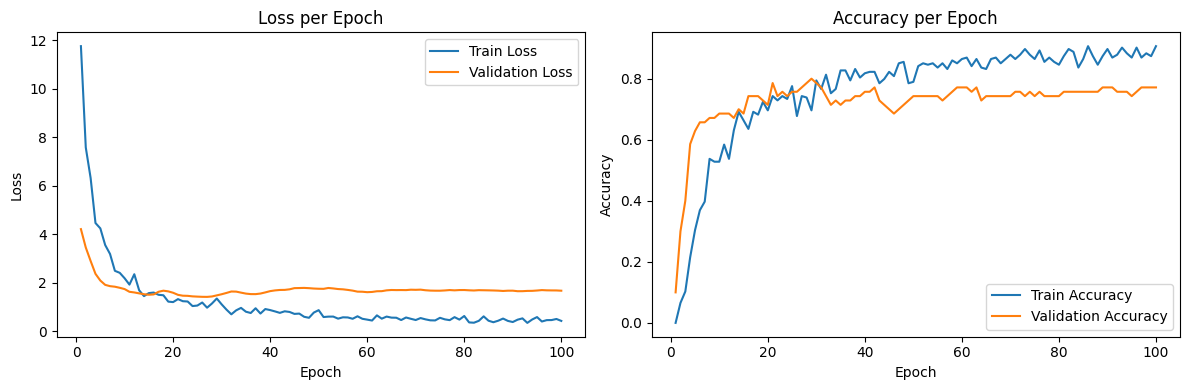

Plot metrics saved to /content/drive/MyDrive/DeepLearningTubes/Results/loss_accuracy_plot.png


In [12]:
save_dir = "/content/drive/MyDrive/DeepLearningTubes/Results"
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'loss_accuracy_plot.png'))
plt.show()
plt.close()
print(f"Plot metrics saved to {os.path.join(save_dir, 'loss_accuracy_plot.png')}")

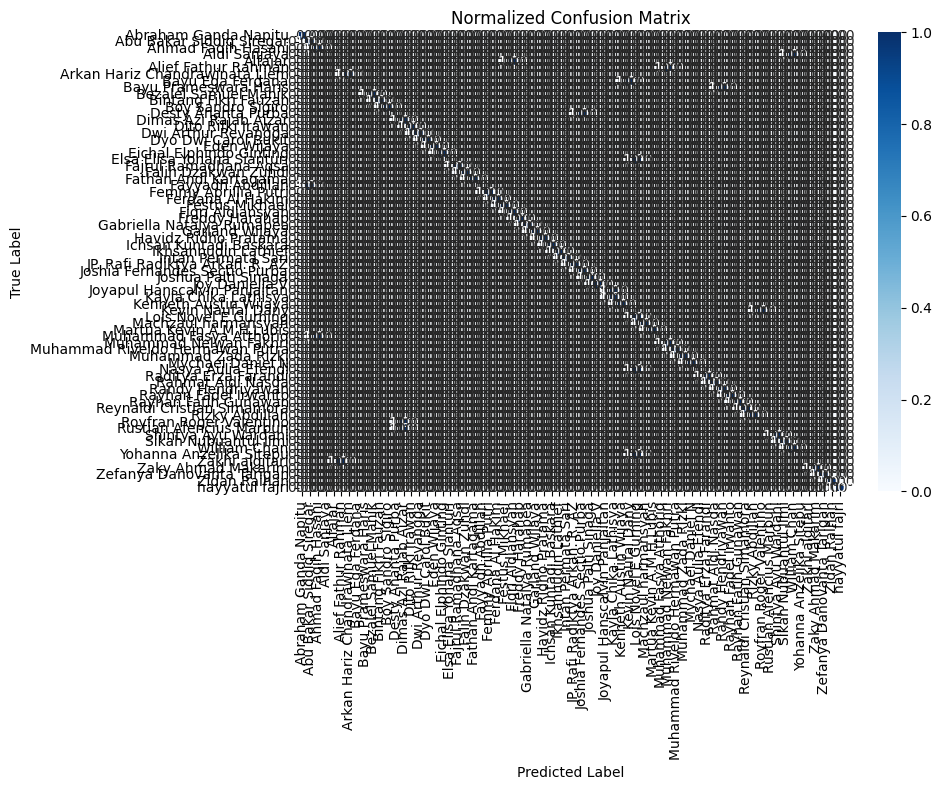

Confusion Matrix saved to /content/drive/MyDrive/DeepLearningTubes/Results/confusion_matrix.png


In [13]:
# Mengambil nama kelas dari label_map
idx_to_class = {v: k for k, v in label_map.items()}
class_names = [idx_to_class[i] for i in sorted(idx_to_class.keys())]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

cm_path = os.path.join(save_dir, 'confusion_matrix.png')
plt.savefig(cm_path)
plt.show()
plt.close()
print(f"Confusion Matrix saved to {cm_path}")

In [14]:
def visualize_predictions(val_ds, y_true, y_pred, label_map, save_dir, num_samples=9):
    """
    Menyimpan grid gambar dengan label asli dan prediksi dari SEMUA sampel val.
    """

    idx_to_class = {v: k for k, v in label_map.items()}

    if num_samples == 70:
        rows, cols = 7, 10
    else:
        # Untuk num_samples lainnya, hitung grid yang mendekati persegi
        cols = math.ceil(num_samples**0.5)
        rows = math.ceil(num_samples / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten()

    all_indices = np.arange(len(y_true))
    # Batasi jumlah yang ditampilkan sesuai num_samples
    sample_indices = all_indices[:min(num_samples, len(all_indices))]
    subtitle = f"All Validation Samples ({len(sample_indices)} shown)"

    # Loop untuk menampilkan gambar
    for i, idx in enumerate(sample_indices):
        if i >= num_samples:
             break

        img_path = val_ds.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)

        true_label = idx_to_class[y_true[idx]]
        pred_label = idx_to_class[y_pred[idx]]

        # Tentukan warna teks berdasarkan benar/salah
        color = 'green' if y_true[idx] == y_pred[idx] else 'red'

        axes[i].imshow(img_np)
        axes[i].axis('off')

        # Buat judul yang lebih terstruktur
        title_text = f"True: {true_label}\nPred: {pred_label}"
        axes[i].set_title(title_text, color=color, fontsize=10, weight='bold')

    # Sembunyikan sisa axes jika jumlah sampel < rows*cols
    for j in range(len(sample_indices), len(axes)):
        axes[j].axis('off')

    plt.suptitle(subtitle, fontsize=16, y=0.98, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    vis_path = os.path.join(save_dir, 'prediction_visuals_all_val.png')
    plt.savefig(vis_path)
    plt.show()
    plt.close()
    print(f"Prediction visuals saved to {vis_path}")

In [15]:
# Visualisasi Gambar Prediksi
visualize_predictions(val_ds, y_true, y_pred, label_map, save_dir, num_samples=70)

save_path = os.path.join("/content/drive/MyDrive/DeepLearningTubes/Models", "Resnet100ArcFace.pth")
torch.save(best_state, save_path)

print("\nTraining complete. Best Val Acc:", best_acc)
print(f"Model saved to: {save_path}")

Output hidden; open in https://colab.research.google.com to view.